# Anime Recommendation System

## Objective: 
    To build a recommendation system by studying, praticing & comparing different approaches and algorithms.
    
    Sub-Objectives:
        - EDA, Data Mining
        - Practice Supervised/Unsupervised techniques



## Recommendation Systems:
    Problem: 
        - Identifying User's need
        - Excess/abundance of options/choices
   
    Solution: Recommend items that user most likely wants.

###### Types:
There are a lot of ideas in case of recommender sytems (recsys). Following are general types:

    - Content Based        
    - Collaborative Filtering (CF)
    - Hybrid Recommender Systems
    - Demographic Based
    - Utility Based
    - Knowledge Based
    
These systems are also divided into following types based on algorithmic approach:

    - Neighborhood Based
    - Latent Factor Model
    - Classification
    
Note: There are many variations/flavors of RecSys depending on Data, Approach & Algorithms being used.


## Scope:    
For this project, I'll start with building a basic model. And move forward from there by applying more complex approaches and comparing the pros & cons along the way.


## RoadMap:
Data Set: Anime Recommendation

###### 1. Fetch Data:
    Files: 
        1. Anime.csv -> 'anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members
        2. Rating.csv -> 'user_id', 'anime_id', 'rating'

###### 2. Wrangle, Prepare and Cleanse Data

###### 3. Analyze, identify patterns, and explore the data.
    - Exploratory Data Analysis
    - Dimensionality Reduction using PCA
    - Clustering using k-means and         
    - Feature Extraction & Feature Selection
    
###### 4. Model, predict/recommendation.
    
######     4.1. Neighborhood Based 
    
        4.1.1 Content Based Recommendation
            - comparing similarity between different items' charactistics.
            - item-item recommendation using item's features covariance matrix for calculating similarity.
           
        4.1.2 Collaborative Filtering 
            i) User-based Filtering 
            ii) Item-based Filtering        
         
######     4.2. Latent Factor Modeling
        Matrix factorization using:
            - Alternating Lease Square (ALS)/Singular Value Decomposition (SVD)/ Stocastic Gradient Descent/LDA
        
######     4.3. Model/Classifier Based Filtering
                
         Predictive Algorithms:
            - Classification: Logistic Regression
            - KNN
            - Bayesian Classifier
            - RBM (Neural Network)
######     4.4. Hybrid Modeling
        Here, we will try to combine different algorithms to overcome different issues like: Accuracy, Cold-start, stability, sparsity etc.
                
######     4.5. Association Rules
    
###### 5. Visualize, report, and present comparison and final solution.

###### 6. Supply the results

---------------------------------------------------------

###### Acknowledgements:
Dataset: Anime recommendation dataset from https://www.kaggle.com/CooperUnion/anime-recommendations-database. 

### 1. Fetch Data

In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
#load data
anime = pd.read_csv('anime.csv')
rating = pd.read_csv('rating.csv')

### 2. Data Wrangling

In [3]:
anime.info()
# what is the relationship of members with anime rating, and count of user ratings, episodes
# missing values in genre, type, rating


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
anime_id    12294 non-null int64
name        12294 non-null object
genre       12232 non-null object
type        12269 non-null object
episodes    12294 non-null object
rating      12064 non-null float64
members     12294 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 672.4+ KB


#### Data Cleaning
Note: 
    - Use rating_count as feature for content based RS.
    - make anime name into vector features using tf-idf/nltk
    - find and remove outliers in the data

In [4]:
# Missing Values

# replace Unknown episodes for Hentai, OVA & Movie with 1
anime.loc[(anime["genre"]=="Hentai") & (anime["episodes"]=="Unknown"),"episodes"] = "1"
anime.loc[(anime["type"]=="OVA") & (anime["episodes"]=="Unknown"),"episodes"] = "1"
anime.loc[(anime["type"] == "Movie") & (anime["episodes"] == "Unknown")] = "1"

# update number of episodes for known till Mar 2017.
known_animes = {"Naruto Shippuuden":500, "One Piece":784,"Detective Conan":854, "Dragon Ball Super":86,
                "Crayon Shin chan":942, "Yu Gi Oh Arc V":148,"Shingeki no Kyojin Season 2":25,
                "Boku no Hero Academia 2nd Season":25,"Little Witch Academia TV":25}

for k,v in known_animes.items():    
    anime.loc[anime["name"]==k,"episodes"] = v

# replace remaining missing episodes with mean value of Type group.
anime["episodes"] = anime["episodes"].map(lambda x:np.nan if x=="Unknown" else x).astype(float)

anime.loc[anime.episodes.isnull(), 'episodes'] = anime.groupby('type').episodes.transform('median')

# replace missing rating with mean value of Type, episodes
anime["rating"] = anime["rating"].astype(float)

anime.loc[anime.rating.isnull(), 'rating'] = anime.groupby('type').rating.transform('mean')

# remove duplicate anime_ids (anime_id =1 , freq=3)
anime.drop_duplicates('anime_id',keep='first',inplace= True)

# remove record with multiple missing columns
anime.dropna(inplace=True)

#anime.to_csv("anime-updated.csv")

In [5]:
# creating user data for analysis
user_data = pd.DataFrame()
user_data['anime_w'] = rating.groupby(by='user_id')['rating'].count()
user_data['anime_r'] = rating[rating.rating > 0].groupby(by='user_id')['rating'].count()
user_data['anime_nr'] = user_data['anime_w'] - user_data['anime_r']


# cleaning rating.csv

# removing outlier from rating.csv
# user_id = 48766 is an outlier which can be observed by plotting graph b/w anime_watch and anime_rated.
# rating by this user are not useful
rating = rating[(rating['user_id'] != 48766) & (rating.rating > 0)]


# drop ratings of removed titles
drop_ratings = set(rating.anime_id.unique()) - set(anime.anime_id.unique())
rating = rating[~rating.anime_id.isin(drop_ratings)]


#user_data.corr()


In [6]:
# feature selection
genre_list = anime["genre"].str.get_dummies(sep=",")
genre_list.drop('1', axis=1,inplace=True)
anime_features = pd.concat([genre_list,pd.get_dummies(anime["type"]),anime[["rating"]],anime[["members"]],anime["episodes"]],axis=1)

## 3. Analyze, identify patterns, and explore the data.
    - Exploratory Data Analysis
    - Dimensionality Reduction using PCA
    - Clustering using k-means
    - Feature Extraction & Feature Selection

In [ ]:
# analyzing genre data
import collections
g_list = [val.strip() for gen in anime['genre'].str.split(",") if type(gen) != float for val in gen]
genre_counter = collections.Counter(g_list)
genres = pd.DataFrame.from_dict(genre_counter, orient='index').reset_index().rename(columns={'index':'genre', 0:'count'})
genres.sort_values('count', ascending=False, inplace=True)

f, ax = plt.subplots(figsize=(8, 12))
sns.barplot(x="count", y="genre", data=genres)
ax.set(ylabel='Genre',xlabel="Anime Count")


In [ ]:

#sns.lmplot('anime_w', 'anime_nr', user_data, fit_reg=False, )
#sns.lmplot('anime_w', 'anime_r', user_data, fit_reg=False)
#user_data.hist('anime_w', bins=25)
user_data[user_data['anime_w'] > 2000].sort_values(by='anime_r', ascending=False)
#user_data.plot()
#user_anime_ids = 
user_anime_ids  = list(rating[rating['user_id']== 28521]['anime_id'])
anime[anime.anime_id in user_anime_ids]
#user_anime_list = anime.anime_id.isin(user_anime_ids)
#user_anime_list

In [50]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=1)
name_vec = list(vectorizer.fit_transform(anime['name']).toarray())


In [5]:
from scipy import sparse
import implicit

# creating user-item rating sparse matrix
user_list = list(np.sort(rating.user_id.unique())) # Get our unique customers
anime_list = list(rating.anime_id.unique()) # Get our unique products that were purchased
rating_list = list(rating.rating) # All of our purchases

rows = rating.user_id.astype('category', categories = user_list).cat.codes 
# Get the associated row indices
cols = rating.anime_id.astype('category', categories = anime_list).cat.codes 
# Get the associated column indices
rating_sparse = sparse.csr_matrix((rating_list, (rows, cols)), shape=(len(user_list), len(anime_list)))

# calculating matrix sparsity
matrix_size = rating_sparse.shape[0]*rating_sparse.shape[1] # Number of possible interactions in the matrix
num_purchases = len(rating_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_purchases/float(matrix_size)))
sparsity



#rating.pivot(index='anime_id', columns='user_id', values='rating')
#n_users = rating.user_id.nunique()
#n_anime = rating.anime_id.nunique()

#print("users: " + str(n_users) + " x  Anime: " + str(n_anime))
#rating.shape



99.08278218350279

In [11]:
alpha = 15
user_vecs, item_vecs = implicit.alternating_least_squares((rating_sparse*alpha).astype('double'), 
                                                          factors=20, 
                                                          regularization = 0.1, 
                                                         iterations = 50)

No handlers could be found for logger "implicit"


In [38]:
anime[anime.anime_id.isin(rating[rating['user_id']==1]['anime_id'])]
#rating[rating.user_id == 1]

,anime_id,name,genre,type,episodes,rating,members
724,15451,High School DxD New,"Action, Comedy, Demons, Ecchi, Harem, Romance,...",TV,12,7.87,266657
804,11757,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100
1057,11617,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School",TV,12,7.70,398660
1709,8074,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892


#### Observation:
    - in order to perform CF on full dataset, we require matrix of 7.8m x 7.8m 
    options:
        i) take sample dataset to perform CF
            - animes rated by a specific number of users (i.e. n> 50: to reduce dataset but increase user behavior detection
        ii) find a way to reduce matrix or handle large matrix in python
            - PyTable : to store tables on disk
            - Scipy : sparse matrix

### Data Mining

Idea:
    - split genres using dummies variables
    - perform eigen vector analysis to find out PC count
    - perform PCA with n_components
    - combine transformed matrix with rest of the features (i.e. type, rating, member, name, count)
    
    does it work any better?

### Dimensionality Reduction 
    - using eigen decomposition

In [16]:
# Calculating Eigenvectors and eigenvalues  Cov matirx
feature_mat = anime_features_scaler # genre_list
mean_vec = np.mean(feature_mat, axis=0)
cov_mat = np.cov(feature_mat.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

# Creating a list of (eigenval, eigenvec) tuples
eig_pairs = [(np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort from high to low
eig_pairs.sort(key = lambda x: x[0], reverse= True)

tot = sum(eig_vals)

exp_var = [ (i/tot)*100 for i in sorted(eig_vals,reverse=True)]

cum_exp_var = np.cumsum(exp_var)
len(exp_var)

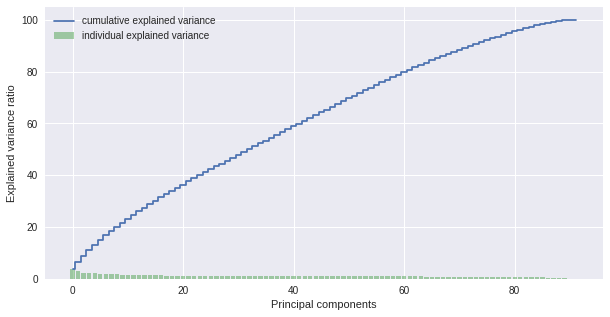

In [21]:
# PLOT OUT THE EXPLAINED VARIANCES SUPERIMPOSED 
plt.figure(figsize=(10, 5))
plt.bar(range(len(exp_var)), exp_var, alpha=0.3333, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(exp_var)), np.cumsum(exp_var), where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

In [136]:
# from above chart we can see about 50 PCs will cover 95% data

# EDA using Unsupervised techniques
# imports
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import kernel_approximation

from pandas.plotting import parallel_coordinates

In [ ]:
# kernel_approximation.

feat_mat = anime_features_scaler
pca = sklearnPCA(n_components=92)
rpca = sklearnPCA(n_components=92, svd_solver='randomized')
lda = LDA(n_components=92)
#transformed = pca.fit_transform(MaxAbsScaler().fit_transform(genre_feature))
transformed = pca.fit_transform(feat_mat)
transformed = rpca.fit_transform(feat_mat)

#headmap to show correlation of pca.components_ with original columns
#df_comp = pd.DataFrame(pca.components_,columns=feat_mat.columns)
#plt.figure(figsize=(20,8))
#sns.heatmap(df_comp,cmap='plasma',)
#sns.clustermap(df_comp,cmap='plasma',)

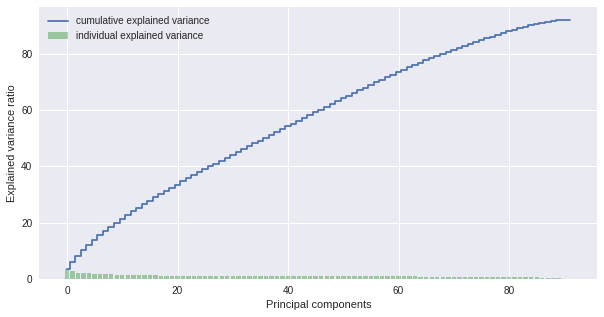

In [41]:
# PLOT OUT THE EXPLAINED VARIANCES SUPERIMPOSED 
plt.figure(figsize=(10, 5))
plt.bar(range(len(rpca.explained_variance_)), rpca.explained_variance_, alpha=0.3333, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(rpca.explained_variance_)), np.cumsum(rpca.explained_variance_), where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

In [24]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 14))
plt.title('Pearson Correlation of Movie Features')
# Draw the heatmap using seaborn
sns.heatmap(pd.DataFrame(transformed).astype(float).corr(),vmax=1.0, square=True, cmap="YlGnBu", linecolor='black', annot=True)

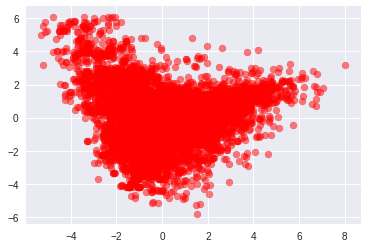

In [176]:
#sns.plt.scatter(pca.components_[1], pca.components_[4])
sns.plt.scatter(transformed[:,1], transformed[:,2],c='r',alpha=0.5)
#sns.plt.scatter(transformed[:,1], transformed[:,2],c='b',alpha=0.5)


In [ ]:
predictions = model.predict(test_user_ids,
                            test_item_ids,
                            user_features=user_features,
                            item_features=item_features)

In [56]:
plt.figure(figsize=(14, 10))
plt.title('Explained Variance Ratio over Component')
plt.plot(pca.explained_variance_ratio_)


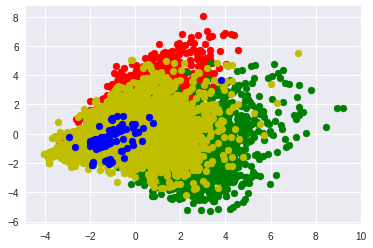

In [177]:
plt.scatter(transformed[genre_feature['Comedy']==1,0],transformed[genre_feature['Comedy']==1,1], c='r')
plt.scatter(transformed[genre_feature['Action']==1,0],transformed[genre_feature['Action']==1,1], c='g')
plt.scatter(transformed[(genre_feature['Comedy']==0) & (genre_feature['Action']==0) & (genre_feature['Sci-Fi']==0),0],transformed[(genre_feature['Comedy']==0) & (genre_feature['Action']==0) & (genre_feature['Sci-Fi']==0),1], c='y')

plt.scatter(transformed[genre_feature['Sci-Fi']==1,0],transformed[genre_feature['Sci-Fi']==1,1], c='b')


In [164]:
# KMeans clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 10)
kmeans.fit(transformed)
labels = kmeans.labels_

In [184]:
pcs_df = pd.DataFrame(transformed)[[3,4,5,10]]
pcs_df['c_labels'] = labels

In [55]:
sns.pairplot(pcs_df, hue='c_labels', palette= 'Dark2', diag_kind='kde',size=1.85)
# plt.scatter(transformed[:,0], transformed[:,1], c=labels, cmap='rainbow', alpha=0.5)

#### Feature Selection
    Create different feature vectors and matrix required to build models in section 4.
    
    There are almost 70k users and 10k anime. Creating a user-item rating matrix would result in a large and very sparse matrix of 70k x 10k. To efficient use resources I'll be using scipy's sparse matrix.

In [9]:
# Create user-item rating sparse matrix
from scipy import sparse

# Get unique user_id
user_list = list(np.sort(rating.user_id.unique())) 

# Get unique anime_id
anime_list = list(rating.anime_id.unique())  

# Get Anime ratings
rating_list = rating.rating.tolist() 

# Get the associated users indices
users_cc = rating.user_id.astype('category', categories = user_list).cat.codes 

# Get the associated anime indices
anime_cc = rating.anime_id.astype('category', categories = anime_list).cat.codes 

# Create a sparse coordinate matrix
rating_sparse = sparse.coo_matrix((rating_list, (users_cc, anime_cc)), shape=(len(user_list), len(anime_list)))

# calculating matrix sparsity
matrix_size = rating_sparse.shape[0]*rating_sparse.shape[1] # Number of possible interactions in the matrix
num_ratings = len(rating_sparse.nonzero()[0]) # Number of anime interacted with
sparsity = 100*(1 - (num_ratings/float(matrix_size)))

print("Info:")
print("Users:\t\t\t" + str(rating_sparse.shape[0]))
print("Anime:\t\t\t" + str(rating_sparse.shape[1]))
print("# of Ratings:\t\t" + str(num_ratings))
print("Matrix Size:\t\t" + str(matrix_size))
print("Matrix sparsity:\t" + str(sparsity))


Info:
Users:			69600
Anime:			9893
# of Ratings:		6337147
Matrix Size:		688552800
Matrix sparsity:	99.0796425488


## 4. Model, predict/recommendation.
    In this section I will try to create different models for recommendation system using different techniques from Data Mining.

###    4.1. Neighborhood Based 
    Recommendations based on similarity of users and/or items.
    

####        4.1.1 Content Based Recommendation
        - Comparing similarity between different anime based on features.
        - item-item recommendation using consine similarity for calculating similarity matrix.

    Procedure:
        - Standardize feature set 
        - Create item-item similarity matrix
        - Generate recommendation based on top similar items.
            

In [339]:
# features scaling
from sklearn.preprocessing import StandardScaler

anime_features_scaler = pd.DataFrame(StandardScaler().fit_transform(anime_features))

In [311]:
# item-item similarity based on item's attributes
from sklearn.metrics.pairwise import cosine_similarity
#from sklearn.metrics import jaccard_similarity_score

sim_mat = cosine_similarity(anime_features_scaler)
sim_mat.shape

(12207, 12207)

In [312]:
# to get anime IDs from partial name
# print(anime[anime.name.str.contains(partial)][['name','anime_id']])
all_anime_names = list(anime.name.values)
def get_id_from_partial_name(partial):
    for name in all_anime_names:
        if partial in name:
            print(name,all_anime_names.index(name))

In [313]:
# sim_mat.shape
def getSimilarItems(item, similarity_matrix, no_of_rec=5):
    sorted_items = np.argsort(similarity_matrix[item])
    reverse_sorted_items = sorted_items[::-1].tolist()
    top_items = reverse_sorted_items[1:no_of_rec+1]
    top_items_name = [anime.iloc[x]['name'] for x in top_items]
    return top_items_name[:no_of_rec]

#### Generating Recommendations:

In [336]:
get_id_from_partial_name('Kenichi')

('Shijou Saikyou no Deshi Kenichi', 260)
('Shijou Saikyou no Deshi Kenichi OVA', 510)
('Shijou Saikyou no Deshi Kenichi Specials', 2128)


In [338]:
getSimilarItems(260, sim_mat)

['Sakigake!! Otokojuku',
 'Kakutou Bijin Wulong: Rebirth',
 'Shijou Saikyou no Deshi Kenichi OVA',
 'Sakigake!! Otokojuku Movie',
 'Shijou Saikyou no Deshi Kenichi Specials']

In [340]:
# Dragon Ball: 346
getSimilarItems(346, sim_mat)

['Dragon Ball Z',
 'Naruto: Shippuuden',
 'Naruto',
 'Dragon Ball Kai',
 'Dragon Ball Super']

##### Content Based RS Observation:
    - we have a matrix of (observations, features) = (12294, 93)
    - in order to generate recommendations, find similarities of each item against all other items.
    - which result in a 12294 x 12294 similarity matrix (151142436 similarity values)
   

#### 4.1.2 Collaborative Filtering 
    Generate recommendations by finding similar users/items using (explicit) rating feedback (user-item rating matrix)
            
    Types:
        i) User-based Filtering
        Find similar users based on their rating data on anime. Recommend anime that other users rated highly.
        
        ii) Item-based Filtering
        Find similar items based on the rating of the users.
        
    Procedure:
        i) Get user-item rating matrix M
        ii) Normalize matrix and perform consine similarity for:
            User Based Filter:
            similarity between rows => sim(M) = 70k x 70k (too large for normal memory)
            Item Based Filter:
            similarity between cols => sim(M.transpose) = 10k x 10k
        iii) Nearest Neighbors
            - get indices and distance of user/item with its neighbors
        iv) Recommend 
            - In case of user based filtering, get nearest neighbors and recommend items from their history based on similarity coefficient.
        
    Pros: 
        i) Personalised Recommendation
        ii) Simple approach

    Cons:
        i) Memory & Computationality Expensive (i.e. sparse data handling, computations on large matrix)
        ii) Cold-start (i.e. system works poorly for user/items with no or less history)
             
    

    Possible Solutions (other than hardware upgrade or algorithm change):
        i) Sample Data Set:
            To avoid memory issues, a sample of data can be used to make our model. However it may result in accuracy loss.
        ii) Use Sparse Matrix:
            To some extent memory issue can also be resolved using sparse matrix (where data is very sparse)


In [371]:
# Make sample data for user-based CF to avoid memory issue.

# Keep rating data for users who have watched anime between 50 and 1500
filtered_users = user_data[(user_data.anime_r > 50) & (user_data.anime_w < 1000)].index.tolist()
sub_rating = rating[rating.user_id.isin(filtered_users)]

# from sub_rating, keep anime with more than 25 user ratings 
anime_rcount = sub_rating.groupby('anime_id')['rating'].count()
sub_rating = sub_rating[sub_rating.anime_id.isin(anime_rcount[anime_rcount > 100].index.tolist())]

anime_ids = sub_rating.anime_id.astype('category', categories = sub_rating.anime_id.unique()).cat.codes
user_ids = sub_rating.user_id.astype('category', categories = sub_rating.user_id.unique()).cat.codes
rating_s = sub_rating.rating



In [7]:
def get_index_from_name(name):
    return anime[anime["name"]==name].index.tolist()[0]
    
def print_similar_animes(query=None,id=None):
    if id:
        for id in indices[id][1:]:
            print(anime.ix[id]["name"])
    if query:
        found_id = get_index_from_name(query)
        for id in indices[found_id][1:]:
            print(anime.ix[id]["name"])


In [10]:
#def get_user_recommendations(user_id, num_of_rec = 10):
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

# For sample data
#item_similarity = pairwise_distances(sub_rating)

# In case of Sparse Matrix 
rating_sparse = rating_sparse.tocsr()
#rating_sparse = normalize(rating_sparse, norm='l1', axis=1)


# Get user-user similarity matrix
# user_similarity = pairwise_distances(rating_sparse, metric='cosine') 

# Get item-item similarity matrix by normalizing columns (transpose of matrix) and calculating consine similarity
item_similarity_sparse = cosine_similarity(normalize(rating_sparse.transpose(), norm='l1', axis=1), dense_output=False)


/home/deeplearning/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


In [11]:
# item-item similarity based on ratings
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=6)
nbrs.fit(item_similarity_sparse)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=6, p=2, radius=1.0)

#### Generating Recommendations:

In [12]:
# search anime to get recommendations for
anime_name = "Blea"

# display related titles (that also exist in ratings)
anime[(anime.name.str.contains(anime_name)) & anime.anime_id.isin(rating.anime_id.unique().tolist())].head()



,anime_id,name,genre,type,episodes,rating,members
582,269,Bleach,"Action, Comedy, Shounen, Super Power, Supernat...",TV,366.0,7.95,624055
946,8247,Bleach Movie 4: Jigoku-hen,"Action, Comedy, Shounen, Super Power, Supernat...",Movie,1.0,7.75,94074
1131,4835,Bleach Movie 3: Fade to Black - Kimi no Na wo ...,"Action, Comedy, Shounen, Super Power, Supernat...",Movie,1.0,7.66,122373
1274,2889,Bleach Movie 2: The DiamondDust Rebellion - Mo...,"Action, Adventure, Shounen, Supernatural",Movie,1.0,7.60,134739
1333,1686,Bleach Movie 1: Memories of Nobody,"Action, Adventure, Super Power",Movie,1.0,7.58,151598


In [13]:
# calc. and display nearest neighbor of anime_id

# Set anime_id to get distances and indices
anime_id = 269
# Angel Beats! 6547

# get similarity col/row index from anime name
similarity_col_id = anime_cc[rating[rating.anime_id == anime_id].index[0]]

# find nearest neighbors
distances, indices = nbrs.kneighbors(item_similarity_sparse[similarity_col_id])

# print indices and their distances
# first match is anime itself
print(distances)
indices

[[ 0.          1.54822235  1.64613411  1.80916427  1.93654043  2.02492846]]


array([[ 134,   35, 1059,    5, 1130, 1205]])

In [15]:
# display recommendations 

# get anime name from similarity
#anime[anime.anime_id == list(rating.loc[anime_cc[anime_cc == 448].index]['anime_id'])[0]]


# get anime list from indices
temp_list = anime_cc[anime_cc.isin(indices[0][1:])]
anime[anime.anime_id.isin(rating.loc[temp_list.drop_duplicates().index]['anime_id'].tolist())]

,anime_id,name,genre,type,episodes,rating,members
175,1604,Katekyo Hitman Reborn!,"Action, Comedy, Shounen, Super Power",TV,203.0,8.37,258103
288,6702,Fairy Tail,"Action, Adventure, Comedy, Fantasy, Magic, Sho...",TV,175.0,8.22,584590
476,9513,Beelzebub,"Action, Comedy, Demons, School, Shounen, Super...",TV,60.0,8.04,217752
841,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220.0,7.81,683297
946,8247,Bleach Movie 4: Jigoku-hen,"Action, Comedy, Shounen, Super Power, Supernat...",Movie,1.0,7.75,94074


#### To-do: Implement Collaborative Filtering using "Weighter Slop One" Recommendations 

Reference Book: Data Mining Ch # 3